#  The LightCurve class

##  Background
#### What kind of physical data are we representing and what do these quantities mean?

Astrophysical variable sources including transients like supernovae are sources that are (roughly) fixed in position but change appreciably at human time scales, such that their measurements at different points of time in a survey are expected to be different. The key science of such sources has to do with interpreting such data.

In a photometric or imaging survey, the raw data associated with such measurements is in the form of a time series of images, along with metadata. This is often extracted into a catalog summarizing the inferred brightness of the source in the filter band and the uncertainties of the inferred. The uncertainties in this process are dominated by the sky noise which is Poisson distributed to a good approximation. Hence, the format of this recorded data is usually of the form

`timestamp`, `flux`, `flux uncertainty`, `zero point`, `magnitude system`

Note that the `flux` is really the band flux obtained in a filter band

The `zero point`, and `magnitude system` are methods of specifying the units of the reported `flux`, and `flux uncertainty`. `flux` may be reported so that the following equation with `bandflux` and `std_bandflux` in the same physical units holds. The `std_bandflux` depends on the transmissions and the magnitude system used.

bandmag := -2.5 log10(bandflux / std_bandflux) = -2.5 log10(flux) + zero point

so that a zero point of zero, implies that `flux` is `bandflux` in units of `std_bandflux`

## Desired Functionality

the `LightCurve` class is meant to be a standard internal representation of this kind of catalog data in our software. This means that 
- given a different format/model of data, we will first convert it into an instance of this class.
- All our calculations will be defined on instances of this class
- We should have write methods to convert the instances of this class to useful formats for serialization.

## Structure

In [1]:
import sncosmo
import analyzeSN as ans
import numpy as np

This requires a THROUGHPUTS directory to be setup as an env var

This may be achieved, for example, by setting up the LSST stack

or by cloning the throughputs directory from git-lfs, 

and setting up env vars. The function is to provide the LSST bandpass

files



In [2]:
from analyzeSN import LightCurve

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/miniconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### Instantiation

The class is instantiated using a constructor that has a mandatory input of a dataframe. and optional inputs. The dataframe must contain the light curve information, and the minimum set of columns required are:
`mjd`, `band`, `flux`, `flux_err`, `zp`, `zpsys` or recognized aliases. Here, we load some data and demonstrate this

In [4]:
ex_data = sncosmo.load_example_data().to_pandas()
ex_data.head()

,time,band,flux,fluxerr,zp,zpsys
0,55070.000000,sdssg,0.363512,0.672844,25.0,ab
1,55072.051282,sdssr,-0.200801,0.672844,25.0,ab
2,55074.102564,sdssi,0.307494,0.672844,25.0,ab
3,55076.153846,sdssz,1.087761,0.672844,25.0,ab
4,55078.205128,sdssg,-0.436679,0.672844,25.0,ab


This was a SNCosmo example dataset, loaded into `pandas.DataFrame`. Note that the column representing temporal information is `time`. Now, we will use this to instantiate our class.

In [5]:
lc = LightCurve(ex_data)

We get the representation in our convention by accessing the attribute `lightCurve`, which is a dataFrame with columns of the standard name. It could have more columns, but the minimal columns have to be there. If we supplied a dataFrame without having the minimal number of columns, it will raise a `valueError`, as described later. From the `lightCurve` attribute, we note that `time` has changed to our standard name `mjd`

In [6]:
lc.lightCurve.head()

,mjd,band,flux,fluxerr,zp,zpsys
0,55070.000000,sdssg,0.363512,0.672844,25.0,ab
1,55072.051282,sdssr,-0.200801,0.672844,25.0,ab
2,55074.102564,sdssi,0.307494,0.672844,25.0,ab
3,55076.153846,sdssz,1.087761,0.672844,25.0,ab
4,55078.205128,sdssg,-0.436679,0.672844,25.0,ab


What would have happened if an essential column was missing? to check let us do the following:
   - We create a dataframe like the above, but remove the essential column band
   - We attempt to create an instance of the LightCurve class

In [7]:
lc_tmp = ex_data.copy()
del lc_tmp['band']
lc_tmp.head()

,time,flux,fluxerr,zp,zpsys
0,55070.000000,0.363512,0.672844,25.0,ab
1,55072.051282,-0.200801,0.672844,25.0,ab
2,55074.102564,0.307494,0.672844,25.0,ab
3,55076.153846,1.087761,0.672844,25.0,ab
4,55078.205128,-0.436679,0.672844,25.0,ab


In [8]:
lc_bad = LightCurve(lc_tmp)

ValueError: ('light curve data has missing columns', set(['band']))

This raises a ValueError pointing out that the column `band` was missing. However, it correctly recognizes that while
`mjd` was missing, it had the aliased column `time` instead and did not report it missing.

### Light Curves in SNCosmo Format

SNCosmo has a data format using `astropy.table.Table`. Since, we use SNCosmo to plot, or fit light curves, it is essential that we can regenerate the SNCosmo format data easily. We do this by the following method

In [9]:
SNCosmoLC = lc.snCosmoLC()

In [10]:
SNCosmoLC

time,band,flux,fluxerr,zp,zpsys
float64,str5,float64,float64,float64,str2
55070.0,sdssg,0.36351153597,0.672843847541,25.0,ab
55072.0512821,sdssr,-0.200801295864,0.672843847541,25.0,ab
55074.1025641,sdssi,0.307494232981,0.672843847541,25.0,ab
55076.1538462,sdssz,1.08776103656,0.672843847541,25.0,ab
55078.2051282,sdssg,-0.43667895645,0.672843847541,25.0,ab
55080.2564103,sdssr,1.09780966779,0.672843847541,25.0,ab
55082.3076923,sdssi,3.7562685627,0.672843847541,25.0,ab
55084.3589744,sdssz,5.34858894966,0.672843847541,25.0,ab
55086.4102564,sdssg,2.82614187269,0.672843847541,25.0,ab


We can now plot the data using the usual SNCosmo plotting method, showing the data in g, r, and z bands.

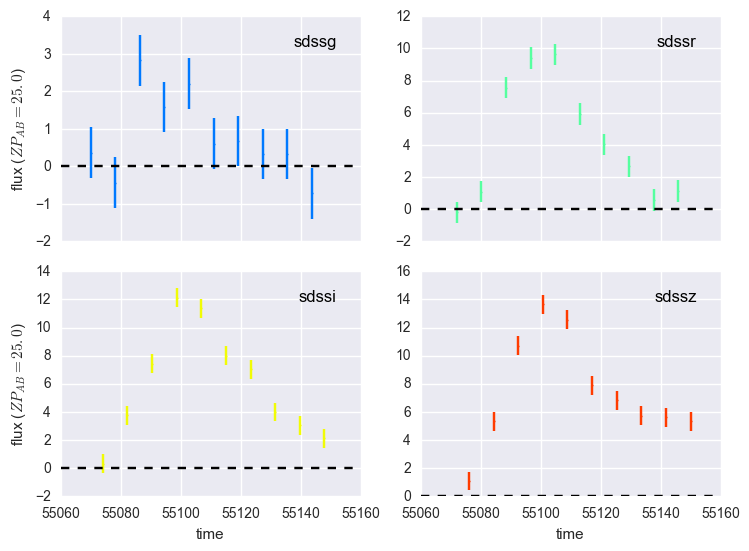

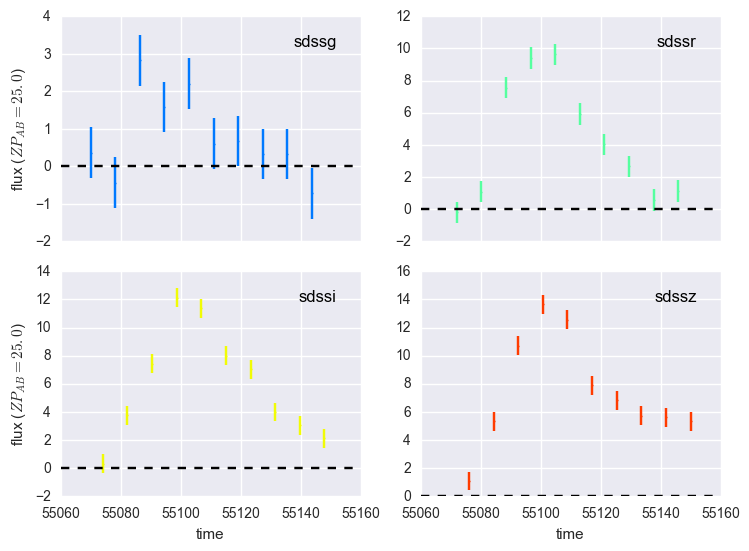

In [11]:
sncosmo.plot_lc(SNCosmoLC)

## SNANA simulations

In [12]:
from analyzeSN import SNANASims

In [13]:
from astropy.table import Table

In [14]:
megacamBandNames = 'ugriz'
megacamRegisteredNames = tuple('mega_' + band for band in megacamBandNames)

In [15]:
snana_eg = SNANASims.fromSNANAfileroot(snanafileroot='snana_fits',
                                       location='../analyzeSN/example_data/',
                                       coerce_inds2int=False,
                                       SNANABandNames=megacamBandNames,
                                       registeredBandNames=megacamRegisteredNames)

In [16]:
Table.read(snana_eg.photFile)[45:50]

MJD,FLT,FIELD,TELESCOPE,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,MAG,MAGERR,PSF_SIG1,PSF_SIG2,PSF_RATIO,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN
float64,str2,str12,str20,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
53023.23,r,NULL,ALL,0,0.0,0.82,1.756,27.717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53026.27,i,NULL,ALL,0,0.0,2.54,2.877,26.487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53026.34,r,NULL,ALL,0,0.0,-3.1,1.816,666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-777.0,-,XXXX,XXXX,0,0.0,-777.0,-777.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52881.5,i,NULL,ALL,0,0.0,-3.9,2.704,666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let us look at what the array in the fits file looks like: 
- It has fields that are not of the standard name (FLUXCAL)
- It has things like "XXX" in he fields

In [17]:
snana_eg.bandNames

'ugriz'

In [18]:
snana_eg.newbandNames

('mega_u', 'mega_g', 'mega_r', 'mega_i', 'mega_z')

In [19]:
lcInstance = snana_eg.get_SNANA_photometry(snid='03D1aw')

In [20]:
lcInstance.lightCurve[['mjd', 'band', 'flux', 'fluxerr', 'zp', 'zpsys']]

,mjd,band,flux,fluxerr,zp,zpsys
0,52881.500,mega_i,13.440000,2.846000,27.5,ab
1,52881.539,mega_r,7.740000,1.701000,27.5,ab
2,52881.559,mega_z,19.719999,6.539000,27.5,ab
3,52886.602,mega_i,44.520000,2.909000,27.5,ab
4,52900.531,mega_i,86.570000,2.914000,27.5,ab
5,52900.559,mega_r,62.169998,2.324000,27.5,ab
6,52900.590,mega_z,84.410004,8.752000,27.5,ab
7,52904.531,mega_i,80.720001,2.710000,27.5,ab
8,52904.570,mega_r,55.090000,2.009000,27.5,ab
9,52908.559,mega_r,54.500000,1.930000,27.5,ab


In [21]:
lcInstance.bandNameDict

{'g': 'mega_g', 'i': 'mega_i', 'r': 'mega_r', 'u': 'mega_u', 'z': 'mega_z'}

In [22]:
snana_eg.headData['REDSHIFT_FINAL']

SNID
03d1aw    0.5817
03d1ax    0.4960
Name: REDSHIFT_FINAL, dtype: float32

## SNSims

In [27]:
import pandas as pd

In [28]:
snsims  = pd.read_hdf('/Users/rbiswas/src/SNsims/examples/simTiles_0.hdf')

## Fitting

In [22]:
import sncosmo

To infer the light curve model parameters, we need a model. We will use the SALT model from SNCosmo

In [35]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2', effects=[dust],
                     effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])

We will not try to infer the redshift first

In [36]:
model.set(z=0.5817)

We have two main methods of trying to infer the model parameters: the first one is a maximum likelihood estimate

In [37]:
resfit = sncosmo.fit_lc(lcInstance.snCosmoLC(), model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=False)

In [38]:
res = sncosmo.mcmc_lc(lcInstance.snCosmoLC(), model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=False)

In [39]:
from analyzeSN import ResChar

In [40]:
reschar = ResChar.fromSNCosmoRes(res)

In [33]:
reschar.salt_samples()['t0'].mean()

52902.329679348411

In [42]:
reschar.salt_samples()['c'].mean()

0.27463205033466986

In [44]:
resfit[0].parameters[2]

7.7076051685948634e-06

In [43]:
resfit[0].parameters[2]

7.7076051685948634e-06

In [49]:
reschar.salt_samples()['c'].std()

0.038004173905723491

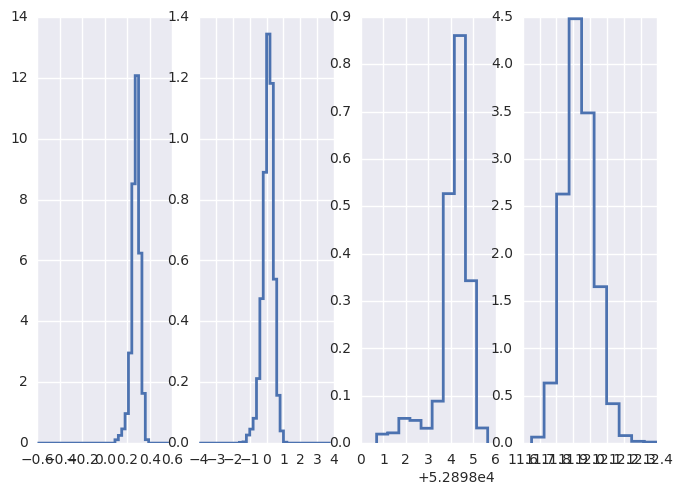

In [70]:
fig, ax  = plt.subplots(1, 4)
reschar.salt_samples()['c'].hist(bins=np.arange(-0.6, 0.6, 0.03), lw=2., histtype='step', normed=1, ax=ax[0])
reschar.salt_samples()['x1'].hist(bins=np.arange(-4., 4., 0.2), lw=2., histtype='step', normed=1, ax=ax[1])
reschar.salt_samples()['t0'].hist(bins=10, lw=2., histtype='step', normed=1, ax=ax[2])
reschar.salt_samples()['mu'].hist(bins=10, lw=2., histtype='step', normed=1, ax=ax[3])

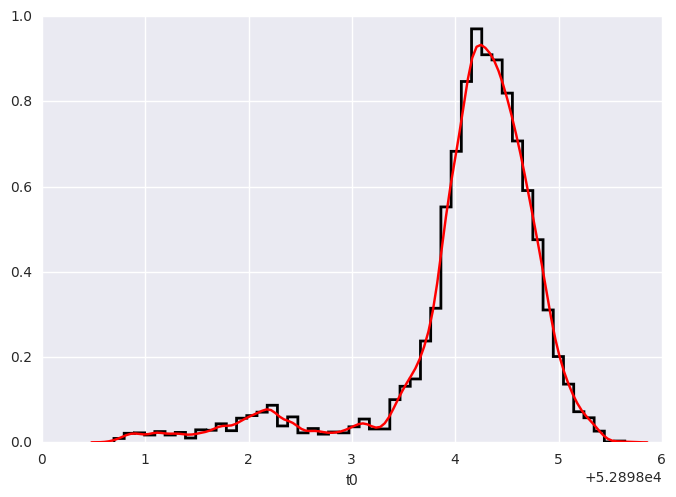

In [80]:
sns.distplot(reschar.salt_samples()['t0'], rug=False, color='r', hist_kws=dict(histtype='step', lw=2., alpha=1., color='k'))

In [47]:
resfit[0].errors['c']

0.029235316112965083

# Scratch

In [ ]:
10**(-0.4 * 0.27)

In [ ]:
-2.5 * np.log10(f) 

In [ ]:
10.0**(0.27 / 2.5 )